In [1]:
import pandas
import math

In [2]:
df = pandas.read_csv('/content/company_directorships.csv')
df.software_background = df.software_background.map(lambda x: x == 't')
df.sample(5)

,company_name,cikcode,director_name,software_background,start_date,end_date
6167,INTERNATIONAL BANCSHARES CORP,315709,"ANTONIO R. SANCHEZ, JR",False,2001-04-17,2001-04-17
1126,"AUTONATION, INC.",350698,LISA LUTOFF-PERLO,False,2020-03-11,2025-03-12
13048,WEYCO GROUP INC,106532,CORY L. NETTLES,False,2012-03-30,2025-04-04
10074,RESERVE PETROLEUM CO,83350,CAMERON R. MCLAIN,False,2006-04-21,2024-04-18
2396,"CITIZENS, INC.",24090,"J. D. ""CHIP"" DAVIS, JR.",False,2018-04-24,2018-04-24


In [3]:
compensation_and_demographics_raw = pandas.read_csv('/content/director-details.csv')
compensation_and_demographics_raw['NAME'] = compensation_and_demographics_raw.name.str.upper()

def most_common(series):
    mode_values = series.mode()
    if len(mode_values) > 0:
        return mode_values[0]
    return None

compensation_and_demographics = pandas.DataFrame({
    'age': compensation_and_demographics_raw.groupby('NAME').age.max(),
    'compensation': compensation_and_demographics_raw.groupby('NAME').compensation.sum(),
    'gender': compensation_and_demographics_raw.groupby('NAME').gender.agg(most_common)
})
compensation_and_demographics['log_compensation'] = (1 + compensation_and_demographics.compensation).map(math.log10)
compensation_and_demographics

,age,compensation,gender,log_compensation
NAME,,,,
A. CATHERINE NGO,64,1006154,female,6.002665
A. EUGENE WASHINGTON,70,324871,male,5.511712
A. F. PETROCELLI,80,47000,male,4.672107
A. FARAZ ABBASI,52,113631,male,5.055501
A. LARRY CHAPMAN,78,259500,male,5.414139
...,...,...,...,...
ZACKARY IRANI,58,360103,male,5.556428
ZAHID AFZAL,62,0,male,0.000000
ZENA SRIVATSA ARNOLD,46,189960,female,5.278664


In [4]:
compensation_and_demographics.gender.value_counts(dropna=False)

,count
gender,
male,3850
female,1550
None,19
unknown,2


In [5]:
directorship_counts = df.groupby('director_name').company_name.nunique().sort_values()
directorship_counts

,company_name
director_name,
MICHAEL LUETKEMEYER,1
MICHAEL L. KUBACKI,1
MICHAEL L. KUTA,1
MICHAEL L. LARUSSO,1
MICHAEL L. MILLER,1
...,...
CHRISTOPHER L. WILSON,13
LARRY SOLL,13
ELI JONES,13


<Axes: xlabel='company_name'>

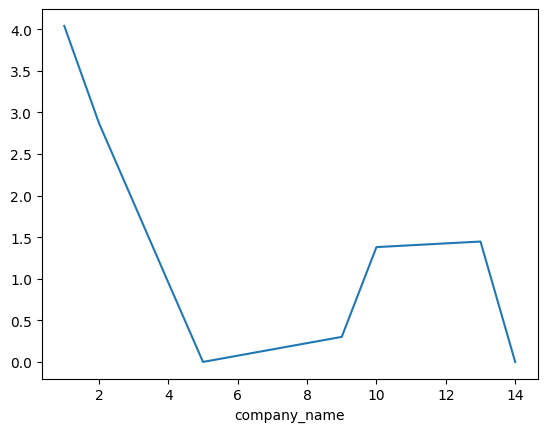

In [6]:
directorship_counts.value_counts().sort_index().map(math.log10).plot()

In [7]:
import networkx
import networkx.algorithms
graph = networkx.Graph()

In [8]:
people = []
companies = []
for company_name, director_name in zip(df.company_name, df.director_name):
    graph.add_edge(company_name, director_name)
    people.append(director_name)
    companies.append(company_name)

In [9]:
biggest_connected_graph = graph.subgraph(list(networkx.connected_components(graph))[0])

In [10]:
%%time
centrality = pandas.DataFrame({
    'eigen': pandas.Series(networkx.eigenvector_centrality(biggest_connected_graph)),
    'degree': pandas.Series(networkx.algorithms.degree_centrality(biggest_connected_graph)),
})
centrality['is_person'] = centrality.index.map(lambda x: x in people)

CPU times: user 3.57 s, sys: 0 ns, total: 3.57 s
Wall time: 3.65 s


In [11]:
people_df = centrality[centrality.is_person].merge(compensation_and_demographics, left_index=True, right_index=True)

In [12]:
people_df.sort_values('eigen', ascending=False)

,eigen,degree,is_person,age,compensation,gender,log_compensation
PREMA MATHAI-DAVIS,1.024389e-01,0.001585,True,74,3208265,female,6.506270
CAROL DECKBAR,1.024389e-01,0.001585,True,62,43263,female,4.636127
CYNTHIA HOSTETLER,1.024389e-01,0.001585,True,62,3371400,female,6.527810
DOUGLAS SHARP,1.024389e-01,0.001585,True,50,0,male,0.000000
"JAMES ""JIM"" LIDDY",1.024389e-01,0.001585,True,65,27531,male,4.439838
...,...,...,...,...,...,...,...
CHARLES A. ZABATTA,8.400282e-35,0.000122,True,82,245000,male,5.389168
ANDREW S. BORODACH,8.342633e-35,0.000122,True,56,0,male,0.000000
LAWRENCE A. KOBRIN,8.342633e-35,0.000122,True,91,30356,male,4.482259
NANCY J. FLOYD PRUE,8.342633e-35,0.000122,True,70,50356,female,4.702060


In [13]:
df[df.director_name == 'ELIZABETH KRENTZMAN']

,company_name,cikcode,director_name,software_background,start_date,end_date
6297,Invesco Advantage Municipal Income Trust II,908993,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6352,Invesco Bond Fund,5094,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6407,Invesco California Value Municipal Income Trust,895531,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6462,Invesco High Income Trust II,846671,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6512,Invesco Municipal Income Opportunities Trust,835333,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6546,Invesco Municipal Opportunity Trust,884152,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6601,Invesco Municipal Trust,877463,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6656,Invesco Pennsylvania Value Municipal Income Trust,895528,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6706,Invesco Quality Municipal Income Trust,885125,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02
6740,Invesco Senior Income Trust,1059386,ELIZABETH KRENTZMAN,False,2021-06-22,2024-07-02


In [14]:
import sklearn.cluster

In [15]:
import sklearn.preprocessing
robust_scaler = sklearn.preprocessing.RobustScaler()
age_and_demographics_scaled = robust_scaler.fit_transform(people_df[['age', 'log_compensation', 'degree', 'eigen']])


In [16]:
dbscan = sklearn.cluster.DBSCAN(eps=0.4)
people_df['cluster_id'] = dbscan.fit_predict(age_and_demographics_scaled)
people_df.cluster_id.value_counts()

,count
cluster_id,
1,3117
0,385
2,109
-1,72
3,24
4,19
7,8
6,5
5,3


<Axes: xlabel='age', ylabel='log_compensation'>

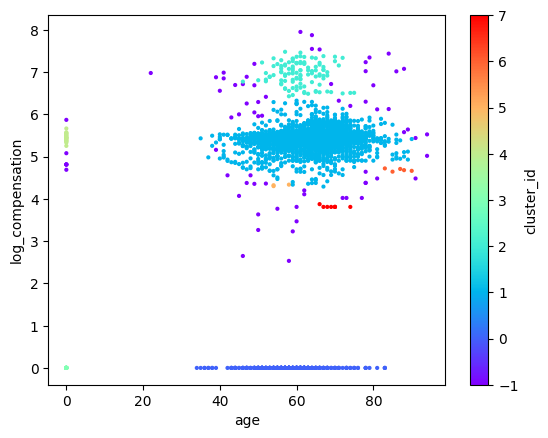

In [17]:
people_df.plot.scatter(x='age', y='log_compensation', c='cluster_id', cmap="rainbow", s=4)

In [18]:
people_df.loc['ELIZABETH KRENTZMAN']

,ELIZABETH KRENTZMAN
eigen,0.102439
degree,0.001585
is_person,True
age,65
compensation,3408245
gender,female
log_compensation,6.532531
cluster_id,2
